### https://docs.google.com/presentation/d/182ZqsIKV6qlBZreN2a21MHxxjmUifajnrezHcci6rtw/edit#slide=id.p

In [1]:
import torch 
import torchvision
import torch.nn.functional as F
from torch import nn, optim
from torchvision import transforms, datasets 

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np



In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [6]:
trainset = datasets.FashionMNIST(root = './', train = True, download = True, transform = transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset = trainset, batch_size = 32, shuffle = True)

In [9]:
## 오토인코더 모듈
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 3)  # 3은 3차원으로 차원축소
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(3,12),
            nn.ReLU(),
            nn.Linear(12,64),
            nn.ReLU(),
            nn.Linear(64,128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded
    
    
        

In [10]:
model = Autoencoder().to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)
criterion = nn.MSELoss()

In [11]:
def train(model, train_loader):
    model.train()
    for step , (data,label) in enumerate(train_loader):
        x = data.view(-1,28*28).to(device)
        y = data.view(-1,28*28).to(device)
        label = label.to(device)

        encoded, decoded = model(x)
        loss = criterion(decoded, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


In [12]:
view_data = trainset.data[:5].view(-1,28*28)
view_data = view_data.type(torch.FloatTensor)/255.

Epoch : 1


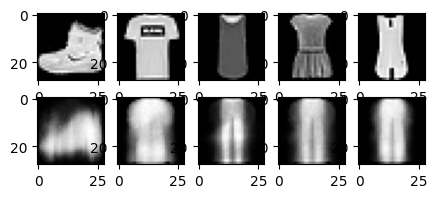

Epoch : 2


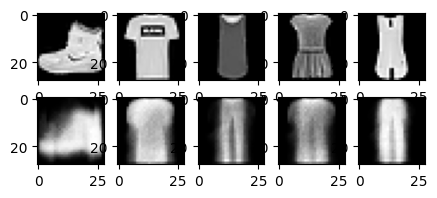

Epoch : 3


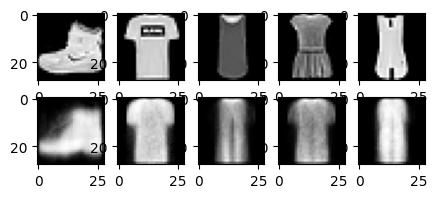

Epoch : 4


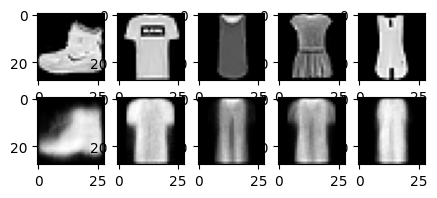

Epoch : 5


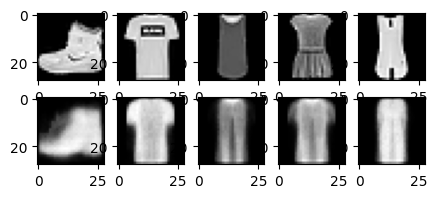

Epoch : 6


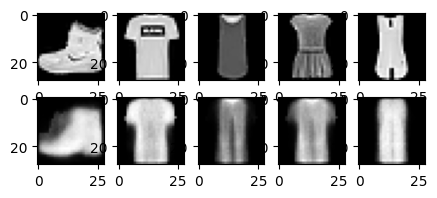

Epoch : 7


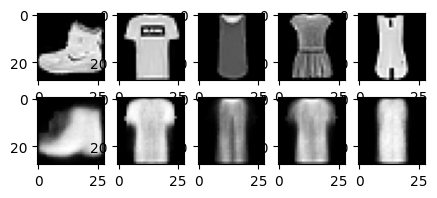

Epoch : 8


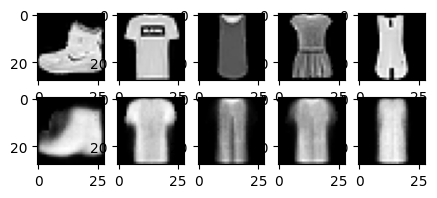

Epoch : 9


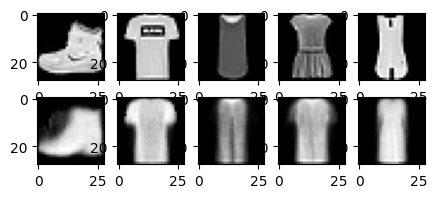

Epoch : 10


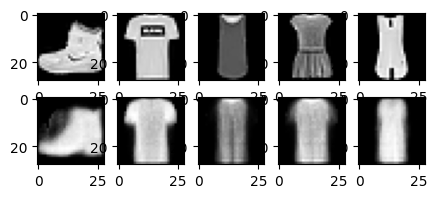

Epoch : 11


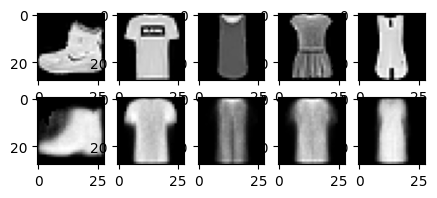

Epoch : 12


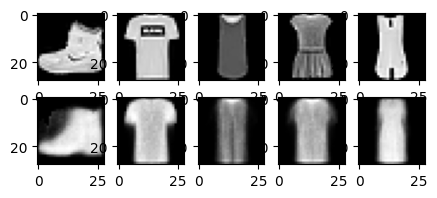

Epoch : 13


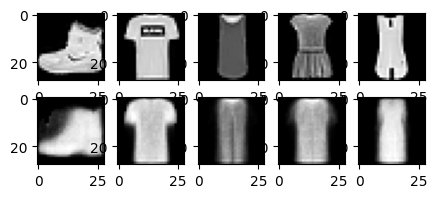

Epoch : 14


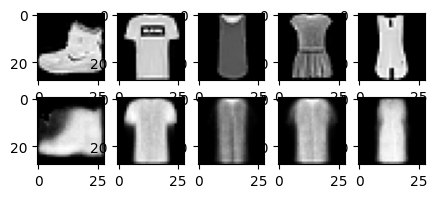

Epoch : 15


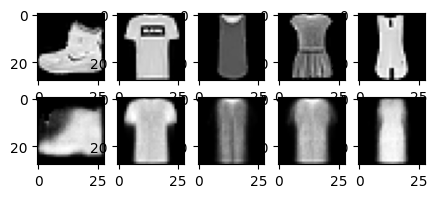

Epoch : 16


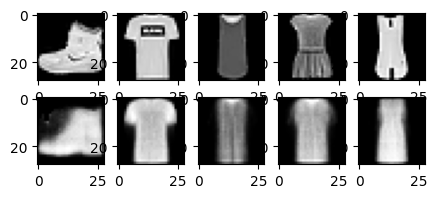

Epoch : 17


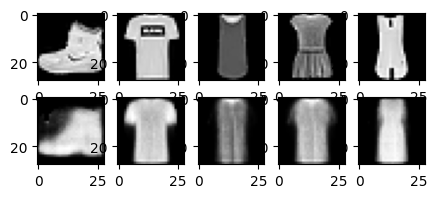

Epoch : 18


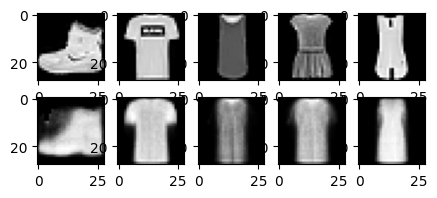

Epoch : 19


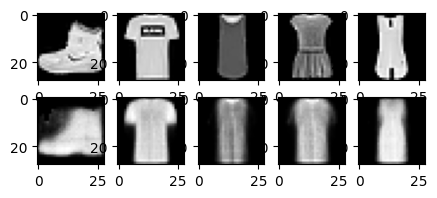

Epoch : 20


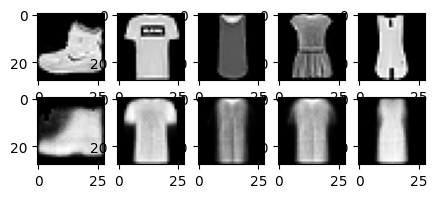

In [13]:
for epoch in range(20):
    train(model, train_loader) # 학습

    test_x = view_data.to(device)
    _,decoded_data = model(test_x)

    f, a = plt.subplots(2,5,figsize=(5,2))

    print(f'Epoch : {epoch+1}')
    for i in range(5):
        img = np.reshape(view_data.data.numpy()[i],(28,28))
        a[0][i].imshow(img, cmap='gray')

    for i in range(5):
        img = np.reshape(decoded_data.to('cpu').data.numpy()[i],(28,28))
        a[1][i].imshow(img, cmap='gray')

    plt.show()
# 세번째 원피스를 보면 바지로 예측하는데 점점 압축된 데이터들이 학습 과정을 거쳐 원피스 모양으로 복원이 된다.

### 이상치 탐지

#### 학습된 데이터 외의 데이터가 들어왔을때 어떻게 될까?


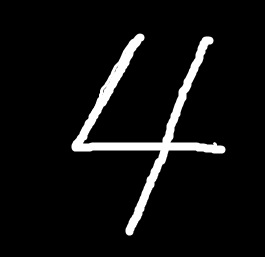

In [16]:
from PIL import Image

img = Image.open('test_img.jpg')
img

In [17]:
img = transforms.ToTensor()(img)
img = transforms.Resize(28)(img)
img = transforms.Grayscale()(img)

img.shape

torch.Size([1, 28, 28])

In [19]:
img = img.unsqueeze(0)
img.size()

torch.Size([1, 1, 28, 28])

In [21]:
img = img.view(-1, 28*28).to(device)
img.size()

torch.Size([1, 784])

In [23]:
_,pred = model(img)
img = np.reshape(pred.to('cpu').data.numpy()[0],(28,28))
img.shape

(28, 28)

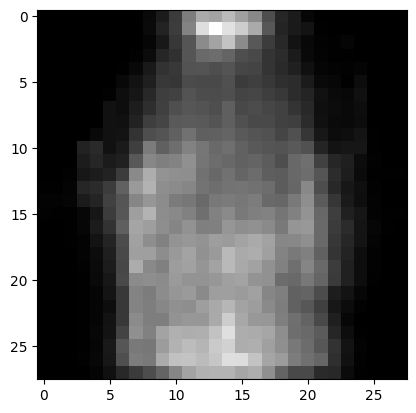

In [24]:
plt.imshow(img, cmap='gray')

### 잠재 벡터 안에 있는 데이터 출력

In [25]:
# z(latent space) 3차원 그래프 시각화
view_data = trainset.data[:200].view(-1,28*28)
view_data = view_data.type(torch.FloatTensor) / 255
test_x = view_data.to(device) # gpu
encoded_data , _ = model(test_x)
encoded_data = encoded_data.to('cpu')


In [26]:
test_x.size()

torch.Size([200, 784])

In [27]:
encoded_data.size()

torch.Size([200, 3])

In [28]:
encoded_data[0]
# 784개의 데이터를이렇게 3개의 숫자로 압축을 시킨것이다. 

tensor([-55.3977,  18.2575, -34.5287], grad_fn=<SelectBackward>)

## 디코더에 무작위 3차원 데이터를 넣었을때 그 값에 해당하는 것을 복원을 시켜준다. 

In [66]:
img = model.decoder(torch.tensor([2.2 , 2.1 , 8.2]).to(device))

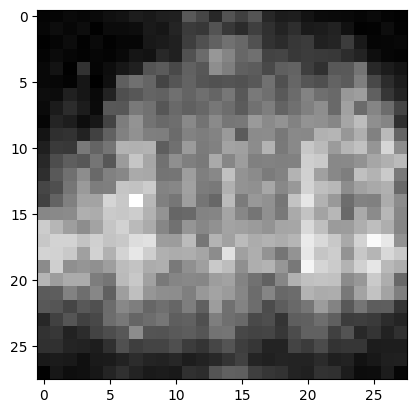

In [67]:
plt.figure()
img = np.reshape(img.to('cpu').data.numpy(),(28,28))
plt.imshow(img, cmap = 'gray')

### 잠재공간을 그대로 그래프로 보여주기

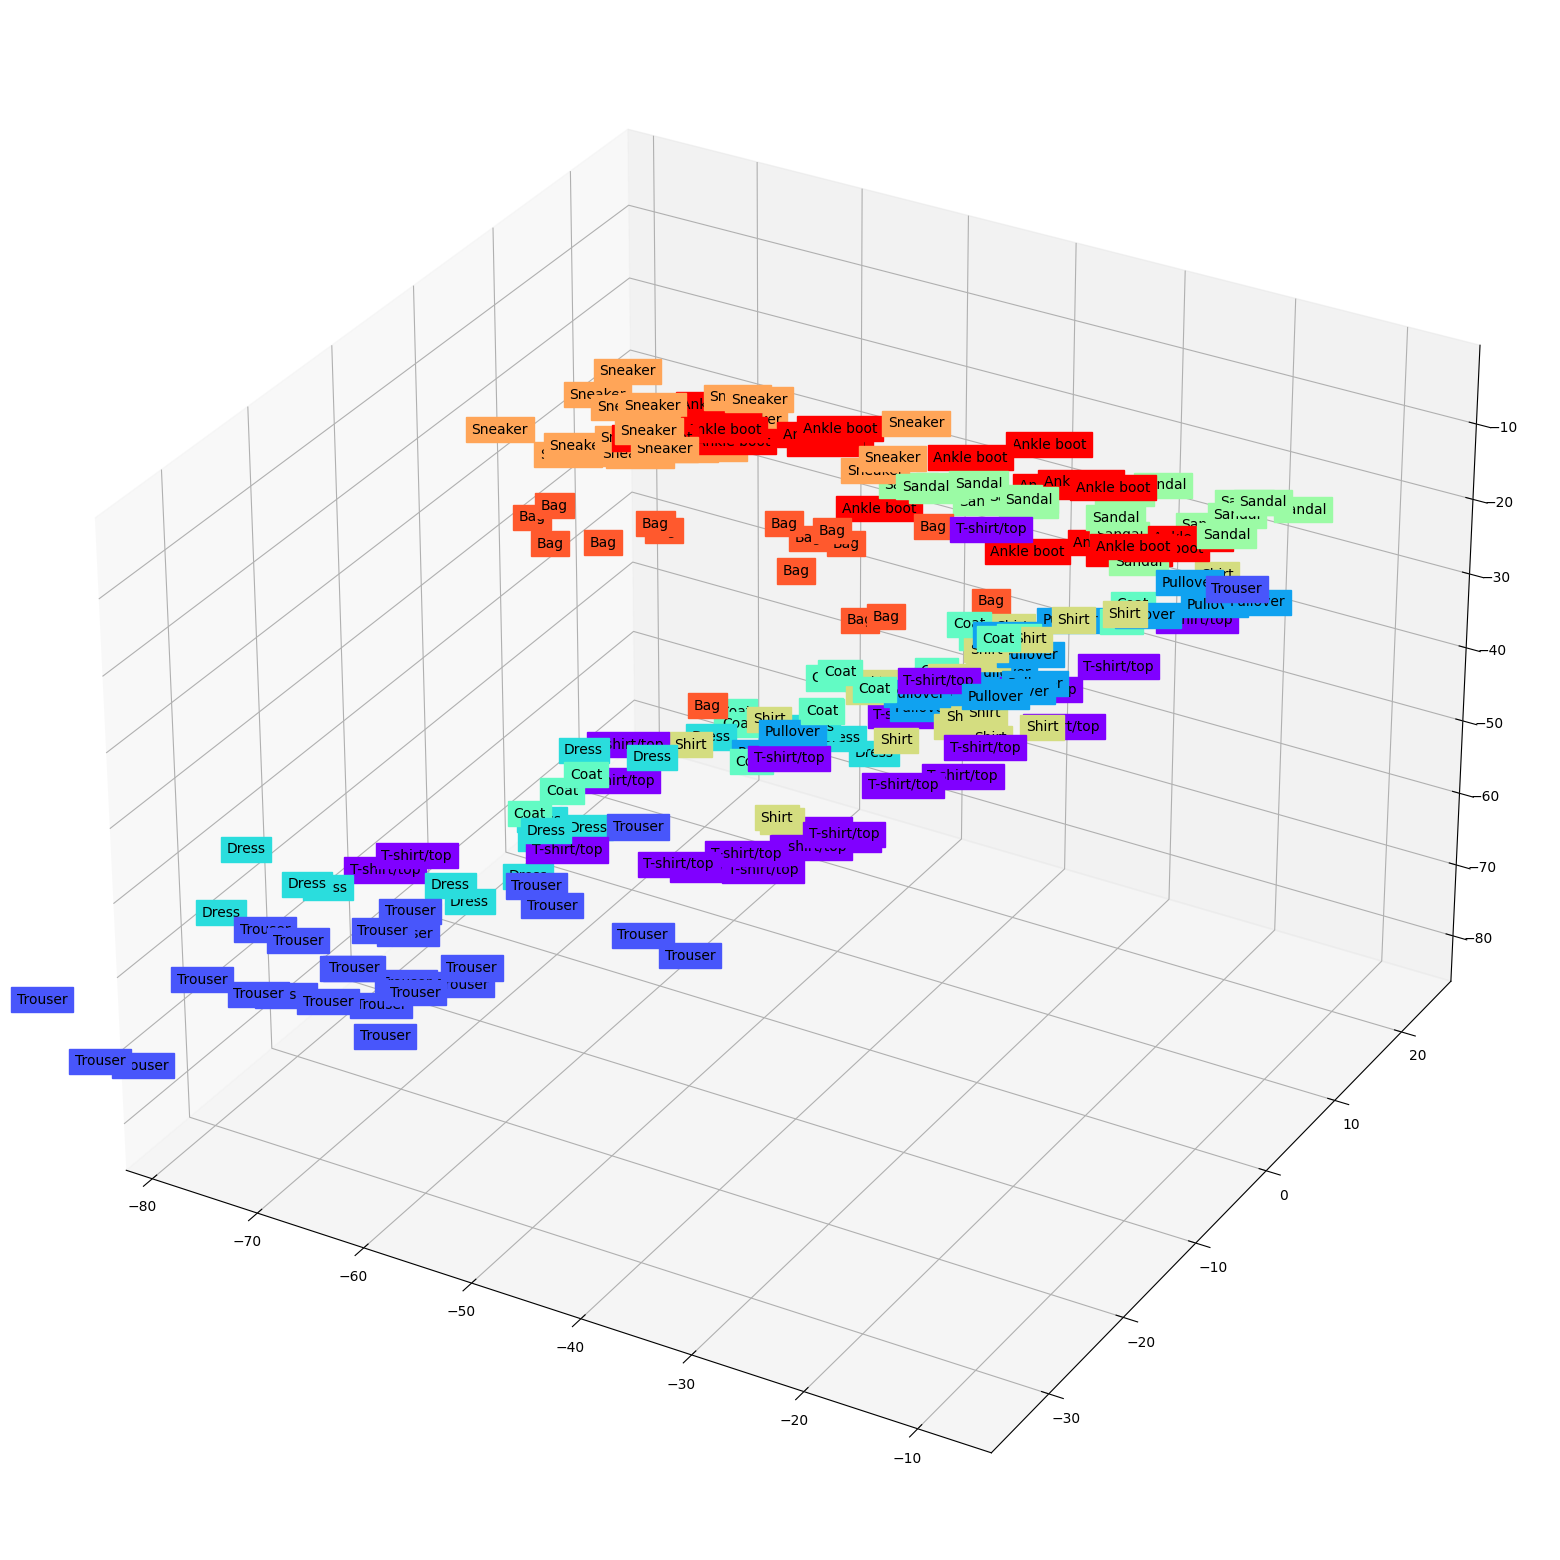

In [77]:
from mpl_toolkits.mplot3d import axes3d

CLASSES = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

fig = plt.figure(figsize = (20,20))
ax = fig.add_subplot(projection = '3d')

X = encoded_data.data[:,0].numpy()
Y = encoded_data.data[:,1].numpy()
Z = encoded_data.data[:,2].numpy()

labels = trainset.targets[:200].numpy()


for x,y,z,s in zip(X,Y,Z,labels):
    name = CLASSES[s]
    color = cm.rainbow(int(255*s/9))
    ax.text(x,y,z,name,backgroundcolor=color)
                       
plot_data = ax.scatter(X,Y,Z,color = 'red')

ax.set_xlim(X.min(), X.max())
ax.set_xlim(Y.min(), Y.max())
ax.set_xlim(Z.min(), Z.max())

plt.show()